In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
data = pd.read_csv('Uber.csv')
data.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [3]:
data.tail()

,dispatching_base_number,date,active_vehicles,trips
349,B02764,2/28/2015,3952,39812
350,B02617,2/28/2015,1372,14022
351,B02682,2/28/2015,1386,14472
352,B02512,2/28/2015,230,1803
353,B02765,2/28/2015,747,7753


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


In [5]:
data.describe()

,active_vehicles,trips
count,354.000000,354.000000
mean,1307.435028,11667.316384
std,1162.510626,10648.284865
min,112.000000,629.000000
25%,296.750000,2408.500000
50%,1077.000000,9601.000000
75%,1417.000000,13711.250000
max,4395.000000,45858.000000


In [6]:
data.dtypes

,0
dispatching_base_number,object
date,object
active_vehicles,int64
trips,int64


In [7]:
data.isnull().sum()

,0
dispatching_base_number,0
date,0
active_vehicles,0
trips,0


In [8]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
Daily_data = data.groupby('date')[['trips', 'active_vehicles']].sum().reset_index()
Daily_data.set_index('date', inplace=True)
print(Daily_data.head())

            trips  active_vehicles
date                              
2015-01-01  56437             6885
2015-01-02  39189             6330
2015-01-03  58449             6510
2015-01-04  40798             5838
2015-01-05  42752             6884


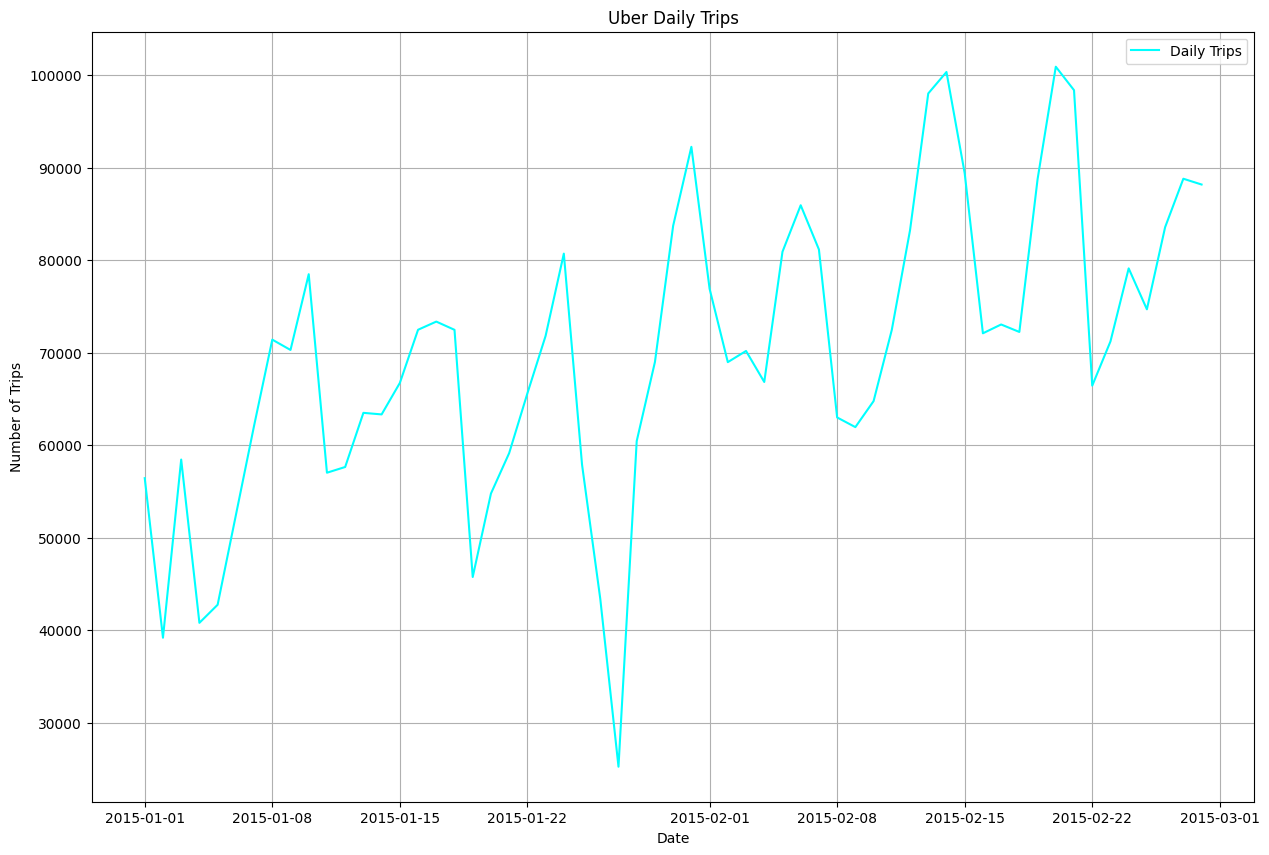

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(Daily_data.index, Daily_data['trips'], label='Daily Trips', color='cyan')
plt.title('Uber Daily Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

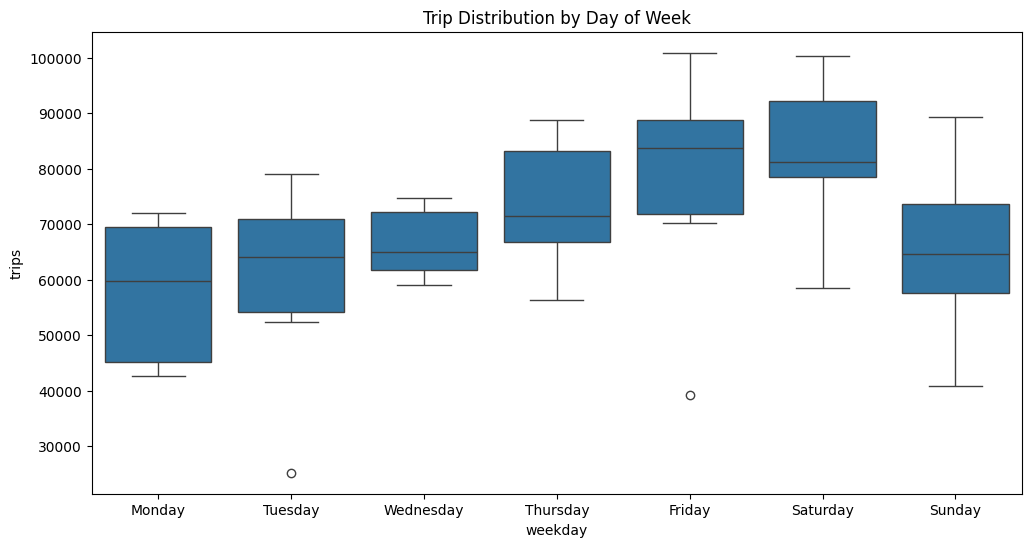

In [10]:
Daily_data['weekday'] = Daily_data.index.day_name()
Daily_data['is_weekend'] = Daily_data.index.weekday >= 7
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='trips', data=Daily_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trip Distribution by Day of Week')
plt.show()

In [11]:
def create_features(data):
    data_1 = data.copy()

    data_1['day_of_week'] = data_1.index.dayofweek
    data_1['is_weekend'] = (data_1.index.weekday >= 5).astype(int)
    data_1['day_of_month'] = data_1.index.day

    for lag in [1, 2, 7]:
        data_1[f'lag_{lag}'] = data_1['trips'].shift(lag)

    data_1['rolling_mean_7'] = data_1['trips'].shift(1).rolling(window=7).mean()
    data_1['rolling_std_7'] = data_1['trips'].shift(1).rolling(window=7).std()

    holidays = pd.to_datetime(['2015-01-01', '2015-01-19', '2015-02-14', '2015-02-16'])
    data_1['is_holiday'] = data_1.index.isin(holidays).astype(int)

    data_1.dropna(inplace=True)
    return data_1
data_2 = create_features(Daily_data)
print(data_2.head(20))

            trips  active_vehicles    weekday  is_weekend  day_of_week  \
date                                                                     
2015-01-08  71413             7999   Thursday           0            3   
2015-01-09  70296             7989     Friday           0            4   
2015-01-10  78484             7346   Saturday           1            5   
2015-01-11  57026             6571     Sunday           1            6   
2015-01-12  57646             7364     Monday           0            0   
2015-01-13  63499             7559    Tuesday           0            1   
2015-01-14  63329             7849  Wednesday           0            2   
2015-01-15  66729             8080   Thursday           0            3   
2015-01-16  72480             8273     Friday           0            4   
2015-01-17  73363             7527   Saturday           1            5   
2015-01-18  72473             6863     Sunday           1            6   
2015-01-19  45755             5945    

In [12]:
test_days = 14
train_data = data_2.iloc[:-test_days]
test_data = data_2.iloc[-test_days:]

X_train = train_data.drop(['trips', 'active_vehicles', 'weekday'], axis=1, errors='ignore')
y_train = train_data['trips']
X_test = test_data.drop(['trips', 'active_vehicles', 'weekday'], axis=1, errors='ignore')
y_test = test_data['trips']

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (38, 9), Test shape: (14, 9)


In [13]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}
results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred

    mape = mean_absolute_percentage_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results[name] = {'MAPE': mape, 'RMSE': rmse}
    print(f"{name} - MAPE: {mape:.4f}, RMSE: {rmse:.2f}")

RandomForest - MAPE: 0.1231, RMSE: 11804.66
GradientBoosting - MAPE: 0.1012, RMSE: 10084.52
XGBoost - MAPE: 0.1656, RMSE: 15675.32


In [14]:
def calculate_ensemble_metrics(results, predictions, y_test):

    total_inv_mape = sum([1/res['MAPE'] for res in results.values()])
    weights = {name: (1/res['MAPE'])/total_inv_mape for name, res in results.items()}
    ensemble_pred = np.zeros_like(y_test, dtype=float)
    for name, pred in predictions.items():
        ensemble_pred += pred * weights[name]

    ens_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
    ens_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

    return weights, ensemble_pred, ens_mape, ens_rmse
weights, ensemble_pred, ens_mape, ens_rmse = calculate_ensemble_metrics(results, predictions, y_test)

print("Ensemble Weights:", weights)
print(f"Ensemble - MAPE: {ens_mape:.4f}, RMSE: {ens_rmse:.2f}")

Ensemble Weights: {'RandomForest': 0.33772845602109014, 'GradientBoosting': 0.41110126995356516, 'XGBoost': 0.2511702740253447}
Ensemble - MAPE: 0.1247, RMSE: 11887.38


In [15]:
df_train_feat = create_features(Daily_data).dropna()
X_train = df_train_feat.drop(['trips', 'active_vehicles', 'weekday'], axis=1)
y_train = df_train_feat['trips']

model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model trained.")

Model trained.


In [16]:
future_days = 10
last_date = Daily_data.index.max()
data_3 = Daily_data.copy()
print(f"Forecasting from {last_date}...")

for i in range(1, future_days + 1):
    next_date = last_date + timedelta(days=i)
    features_for_next_date = {
        'is_weekend': int(next_date.weekday() >= 5),
        'day_of_week': next_date.dayofweek,
        'day_of_month': next_date.day,
        'lag_1': data_3.loc[next_date - timedelta(days=1), 'trips'],
        'lag_2': data_3.loc[next_date - timedelta(days=2), 'trips'],
        'lag_7': data_3.loc[next_date - timedelta(days=7), 'trips'],
        'rolling_mean_7': data_3['trips'].loc[next_date - timedelta(days=7) : next_date - timedelta(days=1)].mean(),
        'rolling_std_7': data_3['trips'].loc[next_date - timedelta(days=7) : next_date - timedelta(days=1)].std(),
        'is_holiday': int(next_date in pd.to_datetime(['2015-01-01', '2015-01-19', '2015-02-14', '2015-02-16']))
    }

    feat_row = pd.DataFrame([features_for_next_date], index=[next_date])
    feat_row = feat_row[X_train.columns]

    pred = model.predict(feat_row)[0]

    data_3.loc[next_date, 'trips'] = pred
    data_3.loc[next_date, 'active_vehicles'] = np.nan
    data_3.loc[next_date, 'weekday'] = next_date.day_name()
    data_3.loc[next_date, 'is_weekend'] = (next_date.weekday() >= 5)

    print(f"{next_date.date()}: {pred:.0f} trips")

forecast = data_3.iloc[future_days:]

Forecasting from 2015-02-28 00:00:00...
2015-03-01: 67385 trips
2015-03-02: 67366 trips
2015-03-03: 70134 trips
2015-03-04: 72280 trips
2015-03-05: 83006 trips
2015-03-06: 85768 trips
2015-03-07: 81783 trips
2015-03-08: 65941 trips
2015-03-09: 65694 trips
2015-03-10: 66708 trips


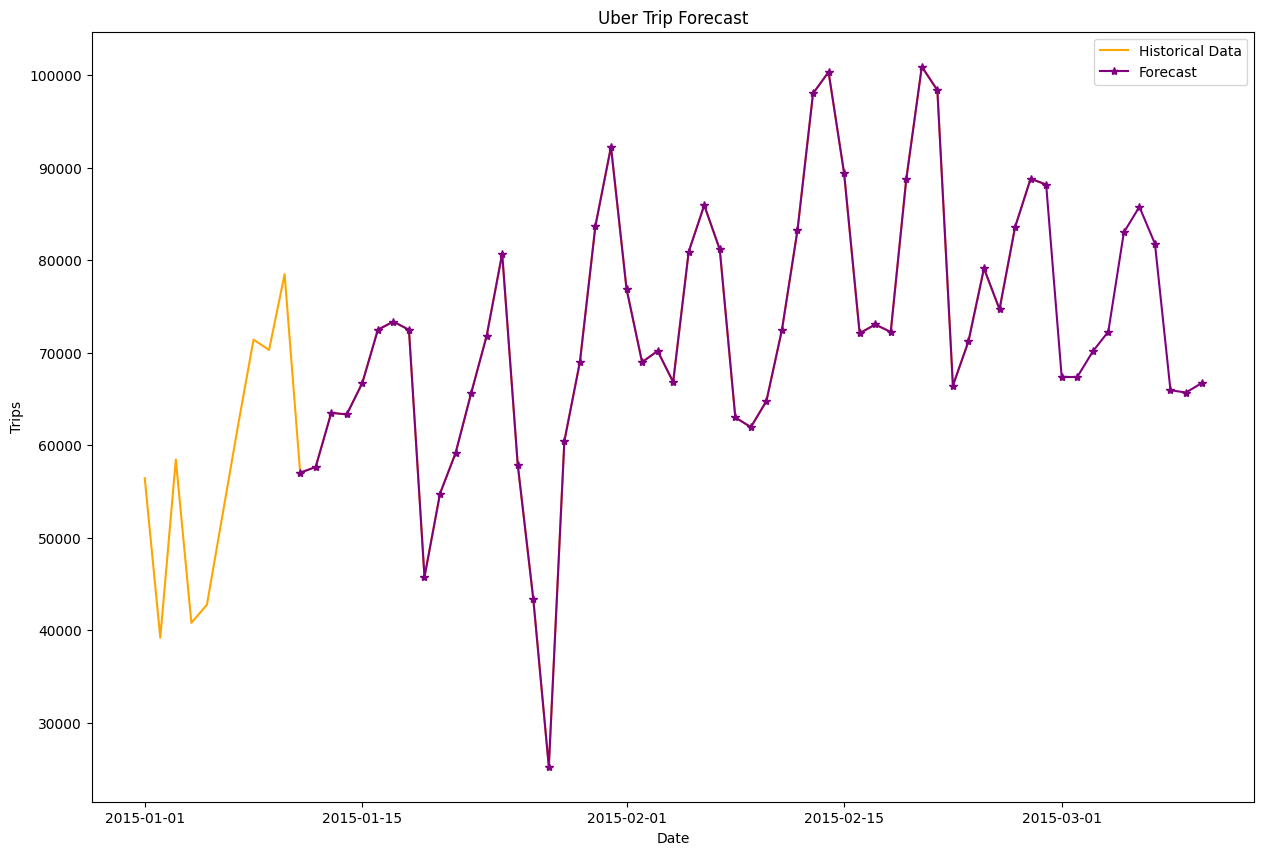

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(Daily_data.index, Daily_data['trips'], label='Historical Data', color='orange')
plt.plot(forecast.index, forecast['trips'], label='Forecast', color='purple', linestyle='-', marker='*')
plt.title('Uber Trip Forecast')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.legend()
plt.show()